### Clustering of Boston Marathon Data

The Boston Marathon is one of the most prestigious races in long distance running. All runners must meet a time qualification that is based on age group. Almost all participants are accomplished, experienced runners. I am interested in seeing if clustering of runners who ran the 2014 Boston Marathon reveals any pattern or strategy in running the race.

In [158]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

%matplotlib inline



### Data Processing
After loading in the csv file for the 2014 marathon results, I removed columns that were unrelated to performance or poorly populated. I cleaned up and then normalized the data.

In [162]:
df = pd.read_csv('boston_marathon_2014_results.csv')
df_copy = df
print(df.columns)
df.head()


Index(['10k', 'name', 'division', '25k', 'gender', 'age', 'official', 'bib',
       'genderdiv', 'ctz', '35k', 'overall', 'pace', 'state', '30k', '5k',
       'half', '20k', 'country', 'city', '40k'],
      dtype='object')


,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [163]:
# Make sure the number of rows divides evenly into four samples.
rows = df.shape[0] - df.shape[0] % 4
df = df.iloc[:rows, :]
df = df.drop(['ctz','state','bib','name','city'],axis=1)
df = df.replace({'-': np.nan}).dropna()
dummies = pd.get_dummies(df['country'])
dummies.head()

,ARG,AUS,AUT,BAH,BAR,BEL,BER,BLR,BOL,BRA,...,TPE,TRI,TUR,UAE,UKR,URU,USA,VEN,VGB,ZIM
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [164]:

df = df.replace({'-': np.nan}).dropna()
X=df
X[['10k', '25k', '35k', '30k','5k','half','20k','40k']] = df[['10k', '25k', '35k', '30k','5k','half','20k','40k']].astype(float)
X = X.drop(['country'],axis =1)
X['gender'] = np.where(X['gender'] == 'M',0,1)

# Join the dummy variables to the main dataframe
#X = pd.concat([X, dummies], axis=1)

cols = list(X)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('overall')))
X = X.ix[:, cols]

X.head()

,overall,10k,division,25k,gender,age,official,genderdiv,35k,pace,30k,5k,half,20k,40k
0,8,17.37,8,47.67,0,47,85.25,8,71.40,3.27,59.18,8.02,39.72,37.65,80.43
1,21,32.58,1,82.43,1,33,138.95,1,116.37,5.30,99.33,16.22,69.47,65.83,132.10
2,1,16.62,1,45.80,0,41,80.60,1,67.42,3.08,56.45,7.75,38.03,36.10,76.10
3,27,32.57,3,82.43,1,24,140.58,3,116.37,5.37,99.33,16.20,69.47,65.83,132.95
4,2,17.12,2,46.37,0,40,81.23,2,67.83,3.10,57.03,8.02,38.60,36.58,76.72


In [165]:

# Normalize the data.
#X_norm = X.drop(['overall'],axis=1)
X_norm = normalize(X)
X_norm = pd.DataFrame(X_norm)
X_norm.head()
print(X.index)

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            31972, 31973, 31976, 31977, 31978, 31979, 31980, 31981, 31982,
            31983],
           dtype='int64', length=31649)


### Finding the best clustering algorithm
I tested kmeans, spectral clustering, mean-shift and affinity propagation algorithms for a variety of cluster sizes to see which resulted in the highest average silhouette coefficient with at low standard deviation between 4 different sample sizes

Kmeans with 9 clusters was the strongest result

In [166]:
# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)


In [112]:
# return lowest average silhouette coeff
def kmean_algorithm(cluster_list):
    counter = 0
    df_model_output = pd.DataFrame(columns=['Algorithm','Number_Clusters','Avg_Silhouette_Coeff','Std_Silhouette_Coeff'])
    for num_clusters in cluster_list:
        sum_kmean = []
        for sample in [X1, X2, X3, X4]: 
            # run k-means
            kmean_model = KMeans(n_clusters=num_clusters, random_state=42).fit(sample)
            kmean_labels = kmean_model.labels_
            sum_kmean.append(metrics.silhouette_score(sample, kmean_labels, metric='euclidean'))
        df_model_output = df_model_output.append({'Algorithm':'Kmeans','Number_Clusters':num_clusters,
                                                          'Avg_Silhouette_Coeff':np.mean(sum_kmean),
                                                           'Std_Silhouette_Coeff': np.std(sum_kmean)}, ignore_index=True)
        counter +=1
    return df_model_output

In [113]:
#initiate a datframe to store the output
df_model_output = pd.DataFrame(columns=['Algorithm','Number_Clusters','Avg_Silhouette_Coeff','Std_Silhouette_Coeff'])
# establish a list for number of clusters
cluster_list = list(range(2,11))
print(cluster_list)


[2, 3, 4, 5, 6, 7, 8, 9, 10]


In [114]:
# run the kmean function and append the results
results_df = kmean_algorithm(cluster_list)

print(results_df)

  Algorithm  Number_Clusters  Avg_Silhouette_Coeff  Std_Silhouette_Coeff
0    Kmeans              2.0              0.453073              0.005607
1    Kmeans              3.0              0.477919              0.003722
2    Kmeans              4.0              0.495126              0.002132
3    Kmeans              5.0              0.409083              0.019581
4    Kmeans              6.0              0.450614              0.003015
5    Kmeans              7.0              0.527596              0.003273
6    Kmeans              8.0              0.533046              0.001732
7    Kmeans              9.0              0.557928              0.001791
8    Kmeans             10.0              0.559121              0.007965


In [ ]:
# run the spectral clustering function and append the results
def sc_algorithm(cluster_list):
    df_model_output = pd.DataFrame(columns=['Algorithm','Number_Clusters','Avg_Silhouette_Coeff','Std_Silhouette_Coeff'])
    for num_clusters in cluster_list:
        sum_sc = []
        for sample in [X1, X2, X3, X4]: 
            # run k-means
            sc = SpectralClustering(n_clusters=num_clusters)
            #sc.fit(sample)
            predict=sc.fit_predict(sample)
            sum_sc.append(metrics.silhouette_score(sample, predict, metric='euclidean'))
        df_model_output = df_model_output.append({'Algorithm':'SC','Number_Clusters':num_clusters,
                                                          'Avg_Silhouette_Coeff':np.mean(sum_sc),
                                                           'Std_Silhouette_Coeff': np.std(sum_sc)}, ignore_index=True)
    return df_model_output



In [212]:
results_sc = sc_algorithm(cluster_list)
results_df = pd.concat([results_df, results_sc])

In [224]:
# run the mean shift function and append the results

def meanshift_algorithm():
    df_model_output = pd.DataFrame(columns=['Algorithm','Number_Clusters','Avg_Silhouette_Coeff','Std_Silhouette_Coeff'])
    sum_ms = []
    for sample in [X1, X2, X3, X4]:
        #bandwidth = estimate_bandwidth(sample, quantile=0.2, n_samples=100)
        # Declare and fit the model.
        ms = MeanShift(bin_seeding=True)
        ms.fit(sample)
        labels = ms.labels_
        cluster_centers = ms.cluster_centers_
        # Count our clusters.
        num_clusters_ = len(np.unique(labels))
        sum_ms.append(metrics.silhouette_score(sample, labels, metric='euclidean'))
    df_model_output = df_model_output.append({'Algorithm':'MS','Number_Clusters':num_clusters_,
                                                          'Avg_Silhouette_Coeff':np.mean(sum_ms),
                                                           'Std_Silhouette_Coeff': np.std(sum_ms)}, ignore_index=True)
    return df_model_output




In [225]:
results_ms = meanshift_algorithm()
results_df = pd.concat([results_df, results_ms])

In [230]:
# run affinity propogation and append the results

def affinitypropogation_algorithm():
    df_model_output = pd.DataFrame(columns=['Algorithm','Number_Clusters','Avg_Silhouette_Coeff','Std_Silhouette_Coeff'])
    sum_ap = []
    for sample in [X1, X2, X3, X4]:
        # Declare and fit the model.
        ap = AffinityPropagation().fit(sample)
        cluster_centers_indices = ap.cluster_centers_indices_
        num_clusters_ = len(cluster_centers_indices)
        labels = ap.labels_
        # Count our clusters.
        num_clusters_ = len(np.unique(labels))
        sum_ap.append(metrics.silhouette_score(sample, labels, metric='euclidean'))
    df_model_output = df_model_output.append({'Algorithm':'AP','Number_Clusters':num_clusters_,
                                                          'Avg_Silhouette_Coeff':np.mean(sum_ap),
                                                           'Std_Silhouette_Coeff': np.std(sum_ap)}, ignore_index=True)
    return df_model_output



In [231]:
results_ap = affinitypropogation_algorithm()
results_df = pd.concat([results_df, results_ap])

In [239]:
results_final = results_df.sort_values(['Avg_Silhouette_Coeff'],ascending=False)
print(results_final)
results_final.to_csv('boston_marathon_alg_eval.csv')

   Algorithm  Number_Clusters  Avg_Silhouette_Coeff  Std_Silhouette_Coeff
8     Kmeans             10.0              0.559117              0.007967
7     Kmeans              9.0              0.557907              0.001818
10    Kmeans             12.0              0.557755              0.003308
9     Kmeans             11.0              0.555689              0.002840
12    Kmeans             14.0              0.550719              0.009582
14    Kmeans             16.0              0.545075              0.001294
13    Kmeans             15.0              0.544825              0.002410
11    Kmeans             13.0              0.543961              0.005912
15    Kmeans             17.0              0.541600              0.005712
16    Kmeans             18.0              0.535645              0.007030
6     Kmeans              8.0              0.533045              0.001732
18    Kmeans             20.0              0.532873              0.012843
5     Kmeans              7.0         

In [244]:
# descriptive statistics on the clusters

In [115]:
kmean_model = KMeans(n_clusters=9, random_state=42).fit(X_norm)
kmean_labels = kmean_model.labels_

X_norm['cluster'] = kmean_labels
X['cluster'] = kmean_labels


In [116]:
#separate data into assigned clusters
cluster_0 = X.loc[X['cluster'] == 0]
cluster_1 = X.loc[X['cluster'] == 1]
cluster_2 = X.loc[X['cluster'] == 2]
cluster_3 = X.loc[X['cluster'] == 3]
cluster_4 = X.loc[X['cluster'] == 4]
cluster_5 = X.loc[X['cluster'] == 5]
cluster_6 = X.loc[X['cluster'] == 6]
cluster_7 = X.loc[X['cluster'] == 7]
cluster_8 = X.loc[X['cluster'] == 8]

#separate clusters by gender
cluster_0f = cluster_0.loc[cluster_0['gender'] == 1]
cluster_0m = cluster_0.loc[cluster_0['gender'] == 0]
cluster_1f = cluster_1.loc[cluster_1['gender'] == 1]
cluster_1m = cluster_1.loc[cluster_1['gender'] == 0]
cluster_2f = cluster_2.loc[cluster_2['gender'] == 1]
cluster_2m = cluster_2.loc[cluster_2['gender'] == 0]
cluster_3f = cluster_3.loc[cluster_3['gender'] == 1]
cluster_3m = cluster_3.loc[cluster_3['gender'] == 0]
cluster_4f = cluster_4.loc[cluster_4['gender'] == 1]
cluster_4m = cluster_4.loc[cluster_4['gender'] == 0]
cluster_5f = cluster_5.loc[cluster_5['gender'] == 1]
cluster_5m = cluster_5.loc[cluster_5['gender'] == 0]
cluster_6f = cluster_6.loc[cluster_6['gender'] == 1]
cluster_6m = cluster_6.loc[cluster_6['gender'] == 0]
cluster_7f = cluster_7.loc[cluster_7['gender'] == 1]
cluster_7m = cluster_7.loc[cluster_7['gender'] == 0]
cluster_8f = cluster_8.loc[cluster_8['gender'] == 1]
cluster_8m = cluster_8.loc[cluster_8['gender'] == 0]


cluster_0f.shape

(4947, 16)

In [117]:
# form new features for average splits between time periods


df_time_0 = pd.DataFrame()
df_time_0['1-10k_avg_split'] = (cluster_0['10k']) / 10
df_time_0['11-20k_avg_split'] = (cluster_0['20k']-cluster_0['10k']) / 10
df_time_0['20-30k_avg_split'] = (cluster_0['30k']-cluster_0['20k']) / 10
df_time_0['30-40k_avg_split'] = (cluster_0['40k']-cluster_0['30k']) / 10

# stack the times and make the new columns for split names the value for a new column
df_time_0f = pd.DataFrame()
df_time_0f = df_time_0.stack()
df_time_0f = pd.DataFrame(df_time_0f)
df_time_0f.reset_index(inplace=True)
df_time_0f = df_time_0f.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'avg_split'})
df_time_0f['cluster'] = 0

df_time_1 = pd.DataFrame()
df_time_1['1-10k_avg_split'] = (cluster_1['10k']) / 10
df_time_1['11-20k_avg_split'] = (cluster_1['20k']-cluster_1['10k']) / 10
df_time_1['20-30k_avg_split'] = (cluster_1['30k']-cluster_1['20k']) / 10
df_time_1['30-40k_avg_split'] = (cluster_1['40k']-cluster_1['30k']) / 10

df_time_1f = pd.DataFrame()
df_time_1f = df_time_1.stack()
df_time_1f = pd.DataFrame(df_time_1f)
df_time_1f.reset_index(inplace=True)
df_time_1f = df_time_1f.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'avg_split'})
df_time_1f['cluster'] = 1

df_time_2 = pd.DataFrame()
df_time_2['1-10k_avg_split'] = (cluster_2['10k']) / 10
df_time_2['11-20k_avg_split'] = (cluster_2['20k']-cluster_2['10k']) / 10
df_time_2['20-30k_avg_split'] = (cluster_2['30k']-cluster_2['20k']) / 10
df_time_2['30-40k_avg_split'] = (cluster_2['40k']-cluster_2['30k']) / 10

df_time_2f = pd.DataFrame()
df_time_2f = df_time_2.stack()
df_time_2f = pd.DataFrame(df_time_2f)
df_time_2f.reset_index(inplace=True)
df_time_2f = df_time_2f.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'avg_split'})
df_time_2f['cluster'] = 2

df_time_3 = pd.DataFrame()
df_time_3['1-10k_avg_split'] = (cluster_3['10k']) / 10
df_time_3['11-20k_avg_split'] = (cluster_3['20k']-cluster_3['10k']) / 10
df_time_3['20-30k_avg_split'] = (cluster_3['30k']-cluster_3['20k']) / 10
df_time_3['30-40k_avg_split'] = (cluster_3['40k']-cluster_3['30k']) / 10

df_time_3f = pd.DataFrame()
df_time_3f = df_time_3.stack()
df_time_3f = pd.DataFrame(df_time_3f)
df_time_3f.reset_index(inplace=True)
df_time_3f = df_time_3f.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'avg_split'})
df_time_3f['cluster'] = 3

df_time_4 = pd.DataFrame()
df_time_4['1-10k_avg_split'] = (cluster_4['10k']) / 10
df_time_4['11-20k_avg_split'] = (cluster_4['20k']-cluster_4['10k']) / 10
df_time_4['20-30k_avg_split'] = (cluster_4['30k']-cluster_4['20k']) / 10
df_time_4['30-40k_avg_split'] = (cluster_4['40k']-cluster_4['30k']) / 10

df_time_4f = pd.DataFrame()
df_time_4f = df_time_4.stack()
df_time_4f = pd.DataFrame(df_time_4f)
df_time_4f.reset_index(inplace=True)
df_time_4f = df_time_4f.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'avg_split'})
df_time_4f['cluster'] = 4

df_time_5 = pd.DataFrame()
df_time_5['1-10k_avg_split'] = (cluster_5['10k']) / 10
df_time_5['11-20k_avg_split'] = (cluster_5['20k']-cluster_5['10k']) / 10
df_time_5['20-30k_avg_split'] = (cluster_5['30k']-cluster_5['20k']) / 10
df_time_5['30-40k_avg_split'] = (cluster_5['40k']-cluster_5['30k']) / 10

df_time_5f = pd.DataFrame()
df_time_5f = df_time_5.stack()
df_time_5f = pd.DataFrame(df_time_5f)
df_time_5f.reset_index(inplace=True)
df_time_5f = df_time_5f.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'avg_split'})
df_time_5f['cluster'] = 5

df_time_6 = pd.DataFrame()
df_time_6['1-10k_avg_split'] = (cluster_6['10k']) / 10
df_time_6['11-20k_avg_split'] = (cluster_6['20k']-cluster_6['10k']) / 10
df_time_6['20-30k_avg_split'] = (cluster_6['30k']-cluster_6['20k']) / 10
df_time_6['30-40k_avg_split'] = (cluster_6['40k']-cluster_6['30k']) / 10

df_time_6f = pd.DataFrame()
df_time_6f = df_time_6.stack()
df_time_6f = pd.DataFrame(df_time_6f)
df_time_6f.reset_index(inplace=True)
df_time_6f = df_time_6f.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'avg_split'})
df_time_6f['cluster'] = 6

df_time_7 = pd.DataFrame()
df_time_7['1-10k_avg_split'] = (cluster_7['10k']) / 10
df_time_7['11-20k_avg_split'] = (cluster_7['20k']-cluster_7['10k']) / 10
df_time_7['20-30k_avg_split'] = (cluster_7['30k']-cluster_7['20k']) / 10
df_time_7['30-40k_avg_split'] = (cluster_7['40k']-cluster_7['30k']) / 10

df_time_7f = pd.DataFrame()
df_time_7f = df_time_7.stack()
df_time_7f = pd.DataFrame(df_time_7f)
df_time_7f.reset_index(inplace=True)
df_time_7f = df_time_7f.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'avg_split'})
df_time_7f['cluster'] = 7

df_time_8 = pd.DataFrame()
df_time_8['1-10k_avg_split'] = (cluster_8['10k']) / 10
df_time_8['11-20k_avg_split'] = (cluster_8['20k']-cluster_8['10k']) / 10
df_time_8['20-30k_avg_split'] = (cluster_8['30k']-cluster_8['20k']) / 10
df_time_8['30-40k_avg_split'] = (cluster_8['40k']-cluster_8['30k']) / 10

df_time_8f = pd.DataFrame()
df_time_8f = df_time_8.stack()
df_time_8f = pd.DataFrame(df_time_8f)
df_time_8f.reset_index(inplace=True)
df_time_8f = df_time_8f.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'avg_split'})
df_time_8f['cluster'] = 8
print(df_time_8f.head())


frames = [df_time_1f, df_time_2f, df_time_3f, df_time_4f, df_time_5f, 
          df_time_6f, df_time_7f, df_time_8f, df_time_0f]

result = pd.concat(frames)
print(result.head(n=50000))



   runner        split_name  avg_split  cluster
0     279   1-10k_avg_split      4.893        8
1     279  11-20k_avg_split      4.749        8
2     279  20-30k_avg_split      4.720        8
3     279  30-40k_avg_split      4.966        8
4     290   1-10k_avg_split      4.678        8
      runner        split_name  avg_split  cluster
0        112   1-10k_avg_split      3.212        1
1        112  11-20k_avg_split      3.303        1
2        112  20-30k_avg_split      4.408        1
3        112  30-40k_avg_split      7.385        1
4        116   1-10k_avg_split      3.378        1
5        116  11-20k_avg_split      3.522        1
6        116  20-30k_avg_split      4.023        1
7        116  30-40k_avg_split      5.807        1
8        224   1-10k_avg_split      3.660        1
9        224  11-20k_avg_split      3.687        1
10       224  20-30k_avg_split      4.056        1
11       224  30-40k_avg_split      4.644        1
12       280   1-10k_avg_split      3.608        

In [154]:
# generate information on negative splits for graphing purposes

# create new fields for 1. the difference in average splits between ranges 2. the boolean of split being negative for each cluster
df_negsplits0 = df_time_0
df_negsplits0_values = pd.DataFrame()
df_negsplits0_bool = pd.DataFrame


df_negsplits0['3-4_neg_split'] = df_negsplits0['30-40k_avg_split'] - df_negsplits0['20-30k_avg_split']
df_negsplits0['3-4_neg_split_bool'] = np.where(df_negsplits0['3-4_neg_split'] < 0, 1, 0)

df_negsplits0['2-3_neg_split'] = df_negsplits0['20-30k_avg_split'] - df_negsplits0['11-20k_avg_split']
df_negsplits0['2-3_neg_split_bool'] = np.where(df_negsplits0['2-3_neg_split'] < 0, 1, 0)

df_negsplits0['1-2_neg_split'] = df_negsplits0['11-20k_avg_split'] - df_negsplits0['1-10k_avg_split']
df_negsplits0['1-2_neg_split_bool'] = np.where(df_negsplits0['1-2_neg_split'] < 0, 1, 0)

df_negsplits0_values = df_negsplits0.filter(['3-4_neg_split','2-3_neg_split','1-2_neg_split'],axis =1)
df_negsplits0_bool = df_negsplits0.filter(['3-4_neg_split_bool','2-3_neg_split_bool','1-2_neg_split_bool'],axis =1)

df_negsplits0_values = df_negsplits0_values.stack()
df_negsplits0_values = pd.DataFrame(df_negsplits0_values)
df_negsplits0_values.reset_index(inplace=True)
df_negsplits0_values = df_negsplits0_values.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'split_difference'})
df_negsplits0_values['cluster'] = 0

df_negsplits0_bool = df_negsplits0_bool.stack()
df_negsplits0_bool = pd.DataFrame(df_negsplits0_bool)
df_negsplits0_bool.reset_index(inplace=True)
df_negsplits0_bool = df_negsplits0_bool.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'neg_split?'})
df_negsplits0_bool['cluster'] = 0


# cluster 1

df_negsplits1 = df_time_1
df_negsplits1_values = pd.DataFrame()
df_negsplits1_bool = pd.DataFrame


df_negsplits1['3-4_neg_split'] = df_negsplits1['30-40k_avg_split'] - df_negsplits1['20-30k_avg_split']
df_negsplits1['3-4_neg_split_bool'] = np.where(df_negsplits1['3-4_neg_split'] < 0, 1, 0)

df_negsplits1['2-3_neg_split'] = df_negsplits1['20-30k_avg_split'] - df_negsplits1['11-20k_avg_split']
df_negsplits1['2-3_neg_split_bool'] = np.where(df_negsplits1['2-3_neg_split'] < 0, 1, 0)

df_negsplits1['1-2_neg_split'] = df_negsplits1['11-20k_avg_split'] - df_negsplits1['1-10k_avg_split']
df_negsplits1['1-2_neg_split_bool'] = np.where(df_negsplits1['1-2_neg_split'] < 0, 1, 0)

df_negsplits1_values = df_negsplits1.filter(['3-4_neg_split','2-3_neg_split','1-2_neg_split'],axis =1)
df_negsplits1_bool = df_negsplits1.filter(['3-4_neg_split_bool','2-3_neg_split_bool','1-2_neg_split_bool'],axis =1)

df_negsplits1_values = df_negsplits1_values.stack()
df_negsplits1_values = pd.DataFrame(df_negsplits1_values)
df_negsplits1_values.reset_index(inplace=True)
df_negsplits1_values = df_negsplits1_values.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'split_difference'})
df_negsplits1_values['cluster'] = 1

df_negsplits1_bool = df_negsplits1_bool.stack()
df_negsplits1_bool = pd.DataFrame(df_negsplits1_bool)
df_negsplits1_bool.reset_index(inplace=True)
df_negsplits1_bool = df_negsplits1_bool.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'neg_split?'})
df_negsplits1_bool['cluster'] = 1

# cluster 2
df_negsplits2 = df_time_2
df_negsplits2_values = pd.DataFrame()
df_negsplits2_bool = pd.DataFrame


df_negsplits2['3-4_neg_split'] = df_negsplits2['30-40k_avg_split'] - df_negsplits2['20-30k_avg_split']
df_negsplits2['3-4_neg_split_bool'] = np.where(df_negsplits2['3-4_neg_split'] < 0, 1, 0)

df_negsplits2['2-3_neg_split'] = df_negsplits2['20-30k_avg_split'] - df_negsplits2['11-20k_avg_split']
df_negsplits2['2-3_neg_split_bool'] = np.where(df_negsplits2['2-3_neg_split'] < 0, 1, 0)

df_negsplits2['1-2_neg_split'] = df_negsplits2['11-20k_avg_split'] - df_negsplits2['1-10k_avg_split']
df_negsplits2['1-2_neg_split_bool'] = np.where(df_negsplits2['1-2_neg_split'] < 0, 1, 0)

df_negsplits2_values = df_negsplits2.filter(['3-4_neg_split','2-3_neg_split','1-2_neg_split'],axis =1)
df_negsplits2_bool = df_negsplits2.filter(['3-4_neg_split_bool','2-3_neg_split_bool','1-2_neg_split_bool'],axis =1)

df_negsplits2_values = df_negsplits2_values.stack()
df_negsplits2_values = pd.DataFrame(df_negsplits2_values)
df_negsplits2_values.reset_index(inplace=True)
df_negsplits2_values = df_negsplits2_values.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'split_difference'})
df_negsplits2_values['cluster'] = 2

df_negsplits2_bool = df_negsplits2_bool.stack()
df_negsplits2_bool = pd.DataFrame(df_negsplits2_bool)
df_negsplits2_bool.reset_index(inplace=True)
df_negsplits2_bool = df_negsplits2_bool.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'neg_split?'})
df_negsplits2_bool['cluster'] = 2

# cluster 3
df_negsplits3 = df_time_3
df_negsplits3_values = pd.DataFrame()
df_negsplits3_bool = pd.DataFrame


df_negsplits3['3-4_neg_split'] = df_negsplits3['30-40k_avg_split'] - df_negsplits3['20-30k_avg_split']
df_negsplits3['3-4_neg_split_bool'] = np.where(df_negsplits3['3-4_neg_split'] < 0, 1, 0)

df_negsplits3['2-3_neg_split'] = df_negsplits3['20-30k_avg_split'] - df_negsplits3['11-20k_avg_split']
df_negsplits3['2-3_neg_split_bool'] = np.where(df_negsplits3['2-3_neg_split'] < 0, 1, 0)

df_negsplits3['1-2_neg_split'] = df_negsplits3['11-20k_avg_split'] - df_negsplits3['1-10k_avg_split']
df_negsplits3['1-2_neg_split_bool'] = np.where(df_negsplits3['1-2_neg_split'] < 0, 1, 0)

df_negsplits3_values = df_negsplits3.filter(['3-4_neg_split','2-3_neg_split','1-2_neg_split'],axis =1)
df_negsplits3_bool = df_negsplits3.filter(['3-4_neg_split_bool','2-3_neg_split_bool','1-2_neg_split_bool'],axis =1)

df_negsplits3_values = df_negsplits3_values.stack()
df_negsplits3_values = pd.DataFrame(df_negsplits3_values)
df_negsplits3_values.reset_index(inplace=True)
df_negsplits3_values = df_negsplits3_values.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'split_difference'})
df_negsplits3_values['cluster'] = 3

df_negsplits3_bool = df_negsplits3_bool.stack()
df_negsplits3_bool = pd.DataFrame(df_negsplits3_bool)
df_negsplits3_bool.reset_index(inplace=True)
df_negsplits3_bool = df_negsplits3_bool.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'neg_split?'})
df_negsplits3_bool['cluster'] = 3

# cluster 4
df_negsplits4 = df_time_4
df_negsplits4_values = pd.DataFrame()
df_negsplits4_bool = pd.DataFrame


df_negsplits4['3-4_neg_split'] = df_negsplits4['30-40k_avg_split'] - df_negsplits4['20-30k_avg_split']
df_negsplits4['3-4_neg_split_bool'] = np.where(df_negsplits4['3-4_neg_split'] < 0, 1, 0)

df_negsplits4['2-3_neg_split'] = df_negsplits4['20-30k_avg_split'] - df_negsplits4['11-20k_avg_split']
df_negsplits4['2-3_neg_split_bool'] = np.where(df_negsplits4['2-3_neg_split'] < 0, 1, 0)

df_negsplits4['1-2_neg_split'] = df_negsplits4['11-20k_avg_split'] - df_negsplits4['1-10k_avg_split']
df_negsplits4['1-2_neg_split_bool'] = np.where(df_negsplits4['1-2_neg_split'] < 0, 1, 0)

df_negsplits4_values = df_negsplits4.filter(['3-4_neg_split','2-3_neg_split','1-2_neg_split'],axis =1)
df_negsplits4_bool = df_negsplits4.filter(['3-4_neg_split_bool','2-3_neg_split_bool','1-2_neg_split_bool'],axis =1)

df_negsplits4_values = df_negsplits4_values.stack()
df_negsplits4_values = pd.DataFrame(df_negsplits4_values)
df_negsplits4_values.reset_index(inplace=True)
df_negsplits4_values = df_negsplits4_values.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'split_difference'})
df_negsplits4_values['cluster'] = 4

df_negsplits4_bool = df_negsplits4_bool.stack()
df_negsplits4_bool = pd.DataFrame(df_negsplits4_bool)
df_negsplits4_bool.reset_index(inplace=True)
df_negsplits4_bool = df_negsplits4_bool.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'neg_split?'})
df_negsplits4_bool['cluster'] = 4

# cluster 5
df_negsplits5 = df_time_5
df_negsplits5_values = pd.DataFrame()
df_negsplits5_bool = pd.DataFrame


df_negsplits5['3-4_neg_split'] = df_negsplits5['30-40k_avg_split'] - df_negsplits5['20-30k_avg_split']
df_negsplits5['3-4_neg_split_bool'] = np.where(df_negsplits5['3-4_neg_split'] < 0, 1, 0)

df_negsplits5['2-3_neg_split'] = df_negsplits5['20-30k_avg_split'] - df_negsplits5['11-20k_avg_split']
df_negsplits5['2-3_neg_split_bool'] = np.where(df_negsplits5['2-3_neg_split'] < 0, 1, 0)

df_negsplits5['1-2_neg_split'] = df_negsplits5['11-20k_avg_split'] - df_negsplits5['1-10k_avg_split']
df_negsplits5['1-2_neg_split_bool'] = np.where(df_negsplits5['1-2_neg_split'] < 0, 1, 0)

df_negsplits5_values = df_negsplits5.filter(['3-4_neg_split','2-3_neg_split','1-2_neg_split'],axis =1)
df_negsplits5_bool = df_negsplits5.filter(['3-4_neg_split_bool','2-3_neg_split_bool','1-2_neg_split_bool'],axis =1)

df_negsplits5_values = df_negsplits5_values.stack()
df_negsplits5_values = pd.DataFrame(df_negsplits5_values)
df_negsplits5_values.reset_index(inplace=True)
df_negsplits5_values = df_negsplits5_values.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'split_difference'})
df_negsplits5_values['cluster'] = 5

df_negsplits5_bool = df_negsplits5_bool.stack()
df_negsplits5_bool = pd.DataFrame(df_negsplits5_bool)
df_negsplits5_bool.reset_index(inplace=True)
df_negsplits5_bool = df_negsplits5_bool.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'neg_split?'})
df_negsplits5_bool['cluster'] = 5

# #neg_splits = pd.DataFrame()
df_negsplits6 = df_time_6
df_negsplits6_values = pd.DataFrame()
df_negsplits6_bool = pd.DataFrame


df_negsplits6['3-4_neg_split'] = df_negsplits6['30-40k_avg_split'] - df_negsplits6['20-30k_avg_split']
df_negsplits6['3-4_neg_split_bool'] = np.where(df_negsplits6['3-4_neg_split'] < 0, 1, 0)

df_negsplits6['2-3_neg_split'] = df_negsplits6['20-30k_avg_split'] - df_negsplits6['11-20k_avg_split']
df_negsplits6['2-3_neg_split_bool'] = np.where(df_negsplits6['2-3_neg_split'] < 0, 1, 0)

df_negsplits6['1-2_neg_split'] = df_negsplits6['11-20k_avg_split'] - df_negsplits6['1-10k_avg_split']
df_negsplits6['1-2_neg_split_bool'] = np.where(df_negsplits6['1-2_neg_split'] < 0, 1, 0)

df_negsplits6_values = df_negsplits6.filter(['3-4_neg_split','2-3_neg_split','1-2_neg_split'],axis =1)
df_negsplits6_bool = df_negsplits6.filter(['3-4_neg_split_bool','2-3_neg_split_bool','1-2_neg_split_bool'],axis =1)

df_negsplits6_values = df_negsplits6_values.stack()
df_negsplits6_values = pd.DataFrame(df_negsplits6_values)
df_negsplits6_values.reset_index(inplace=True)
df_negsplits6_values = df_negsplits6_values.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'split_difference'})
df_negsplits6_values['cluster'] = 6

df_negsplits6_bool = df_negsplits6_bool.stack()
df_negsplits6_bool = pd.DataFrame(df_negsplits6_bool)
df_negsplits6_bool.reset_index(inplace=True)
df_negsplits6_bool = df_negsplits6_bool.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'neg_split?'})
df_negsplits6_bool['cluster'] = 6

# cluster 7

df_negsplits7 = df_time_7
df_negsplits7_values = pd.DataFrame()
df_negsplits7_bool = pd.DataFrame

df_negsplits7['3-4_neg_split'] = df_negsplits7['30-40k_avg_split'] - df_negsplits7['20-30k_avg_split']
df_negsplits7['3-4_neg_split_bool'] = np.where(df_negsplits7['3-4_neg_split'] < 0, 1, 0)

df_negsplits7['2-3_neg_split'] = df_negsplits7['20-30k_avg_split'] - df_negsplits7['11-20k_avg_split']
df_negsplits7['2-3_neg_split_bool'] = np.where(df_negsplits7['2-3_neg_split'] < 0, 1, 0)

df_negsplits7['1-2_neg_split'] = df_negsplits7['11-20k_avg_split'] - df_negsplits7['1-10k_avg_split']
df_negsplits7['1-2_neg_split_bool'] = np.where(df_negsplits7['1-2_neg_split'] < 0, 1, 0)

df_negsplits7_values = df_negsplits7.filter(['3-4_neg_split','2-3_neg_split','1-2_neg_split'],axis =1)
df_negsplits7_bool = df_negsplits7.filter(['3-4_neg_split_bool','2-3_neg_split_bool','1-2_neg_split_bool'],axis =1)

df_negsplits7_values = df_negsplits7_values.stack()
df_negsplits7_values = pd.DataFrame(df_negsplits7_values)
df_negsplits7_values.reset_index(inplace=True)
df_negsplits7_values = df_negsplits7_values.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'split_difference'})
df_negsplits7_values['cluster'] = 7

df_negsplits7_bool = df_negsplits7_bool.stack()
df_negsplits7_bool = pd.DataFrame(df_negsplits7_bool)
df_negsplits7_bool.reset_index(inplace=True)
df_negsplits7_bool = df_negsplits7_bool.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'neg_split?'})
df_negsplits7_bool['cluster'] = 7

# cluster 8
df_negsplits8 = df_time_8
df_negsplits8_values = pd.DataFrame()
df_negsplits8_bool = pd.DataFrame

df_negsplits8['3-4_neg_split'] = df_negsplits8['30-40k_avg_split'] - df_negsplits8['20-30k_avg_split']
df_negsplits8['3-4_neg_split_bool'] = np.where(df_negsplits8['3-4_neg_split'] < 0, 1, 0)

df_negsplits8['2-3_neg_split'] = df_negsplits8['20-30k_avg_split'] - df_negsplits8['11-20k_avg_split']
df_negsplits8['2-3_neg_split_bool'] = np.where(df_negsplits8['2-3_neg_split'] < 0, 1, 0)

df_negsplits8['1-2_neg_split'] = df_negsplits8['11-20k_avg_split'] - df_negsplits8['1-10k_avg_split']
df_negsplits8['1-2_neg_split_bool'] = np.where(df_negsplits8['1-2_neg_split'] < 0, 1, 0)

df_negsplits8_values = df_negsplits8.filter(['3-4_neg_split','2-3_neg_split','1-2_neg_split'],axis =1)
df_negsplits8_bool = df_negsplits8.filter(['3-4_neg_split_bool','2-3_neg_split_bool','1-2_neg_split_bool'],axis =1)

df_negsplits8_values = df_negsplits8_values.stack()
df_negsplits8_values = pd.DataFrame(df_negsplits8_values)
df_negsplits8_values.reset_index(inplace=True)
df_negsplits8_values = df_negsplits8_values.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'split_difference'})
df_negsplits8_values['cluster'] = 8

df_negsplits8_bool = df_negsplits8_bool.stack()
df_negsplits8_bool = pd.DataFrame(df_negsplits8_bool)
df_negsplits8_bool.reset_index(inplace=True)
df_negsplits8_bool = df_negsplits8_bool.rename(columns={'level_0': 'runner', 'level_1':'split_name', 0:'neg_split?'})
df_negsplits8_bool['cluster'] = 8

frames_values = [df_negsplits0_values, df_negsplits1_values, df_negsplits2_values, df_negsplits3_values, df_negsplits4_values, 
           df_negsplits5_values, df_negsplits6_values, df_negsplits7_values,df_negsplits8_values]

result_values = pd.concat(frames_values)

frames_bool = [df_negsplits0_bool, df_negsplits1_bool, df_negsplits2_bool, df_negsplits3_bool, df_negsplits4_bool, 
           df_negsplits5_bool, df_negsplits6_bool, df_negsplits7_bool,df_negsplits8_bool]

result_bool = pd.concat(frames_bool)


AttributeError: Unknown property font_size

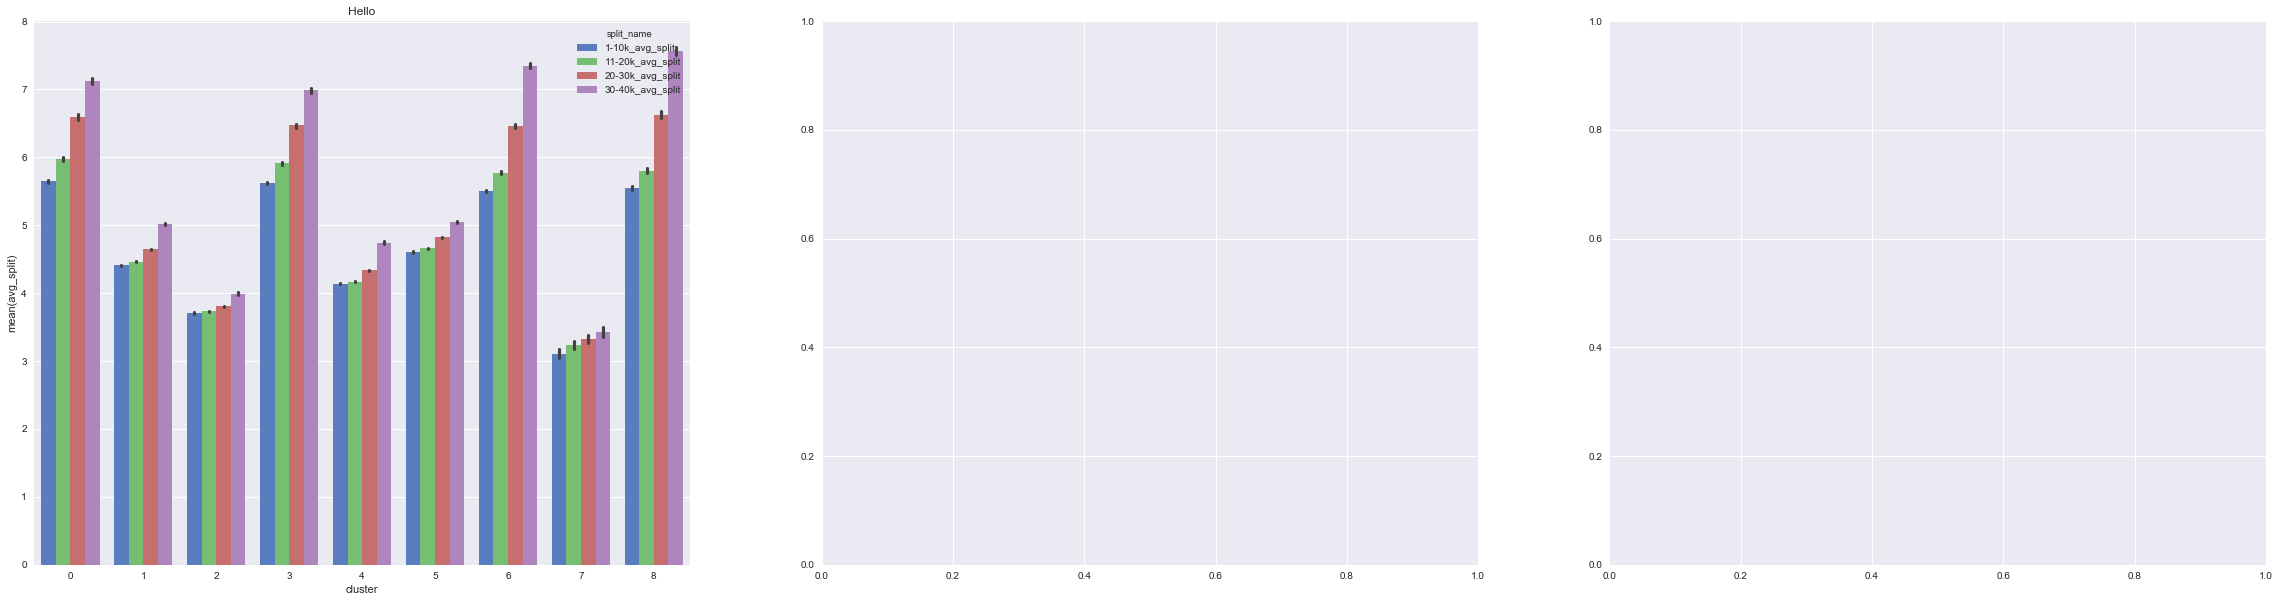

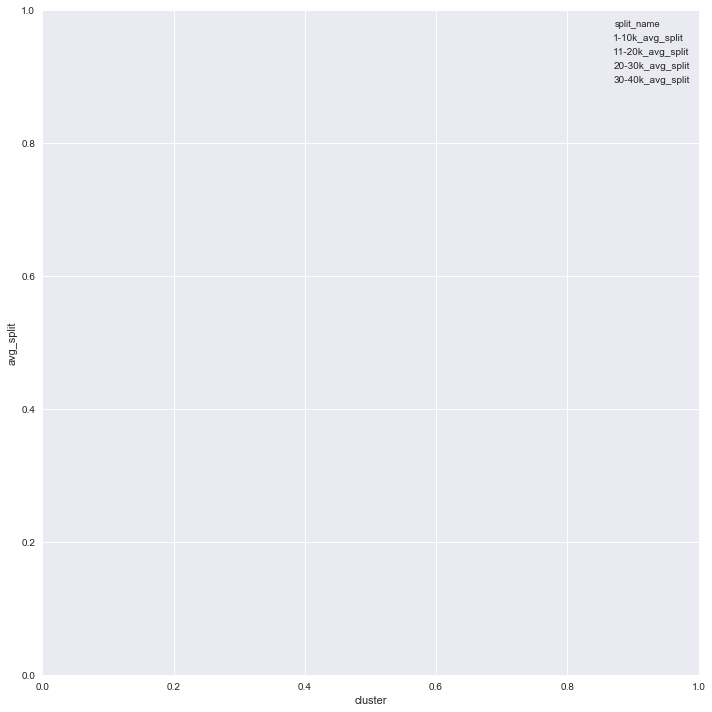

In [173]:


fig = plt.figure(figsize=(40,10))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)



g = sns.factorplot("cluster", "avg_split", "split_name",
                    data=result, kind="bar",
                    size=10, palette="muted",
                   legend_out=False,ax=ax1)
ax1.set_title('Hello',font_size=20)
g2 = sns.factorplot("cluster", "split_difference", "split_name",
                    data=result_values, kind="bar",
                    size=10, palette="muted",
                   legend_out=False,ax=ax2)

g3 = sns.factorplot("cluster", "neg_split?", "split_name",
                    data=result_bool, kind="bar",
                    size=10, palette="muted",
                   legend_out=False,ax=ax3)

plt.close(g.fig)
plt.close(g2.fig)
plt.close(g3.fig)

plt.show()

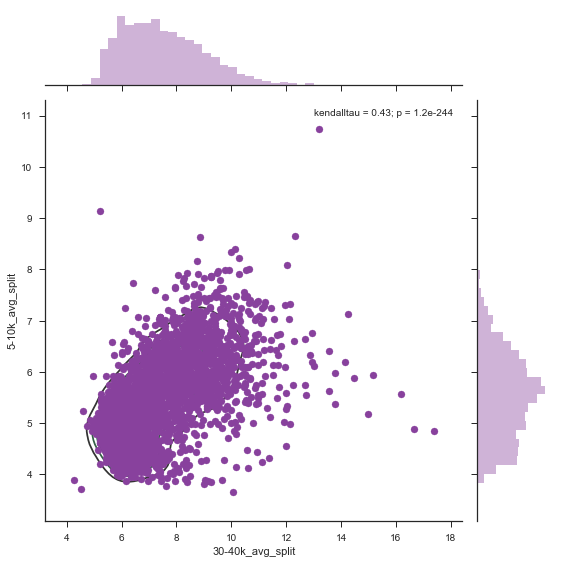

In [394]:

# Setting the three non-data columns to work as multi-indices. 
# This makes it much easier to get subsections of stacked data.
data_test = data.set_index(['groups','size','variability'])

# Storing our t-values and p-values (we'll get to p-values in a sec).
tvalues=[]
pvalues=[]

#For each combination of sample size and variability, compare the two groups using a t-test
for size in sizes:
    for var in variability:
        a = df_time_0f['avg_split'].xs(('group1',size,var),level=('groups','size','variability'))
        b = data_test['data'].xs(('group2',size,var),level=('groups','size','variability'))
        tval,pval=stats.ttest_ind(b, a,equal_var=True)
        tvalues.append(tval)
        pvalues.append(pval)

